In [36]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pandas.plotting import parallel_coordinates
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from time import time
from sklearn import metrics
%matplotlib inline


In [37]:

# define the size of the outout graph in later
size = (10, 6)

# load data
data_set = pd.read_csv('winequality-red.csv',sep=';')
X = data_set.iloc[:, 0:11]
y = data_set.iloc[:, -1]
X.head(5)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [38]:
print(min(y),
      max(y))

3 8


<AxesSubplot:>

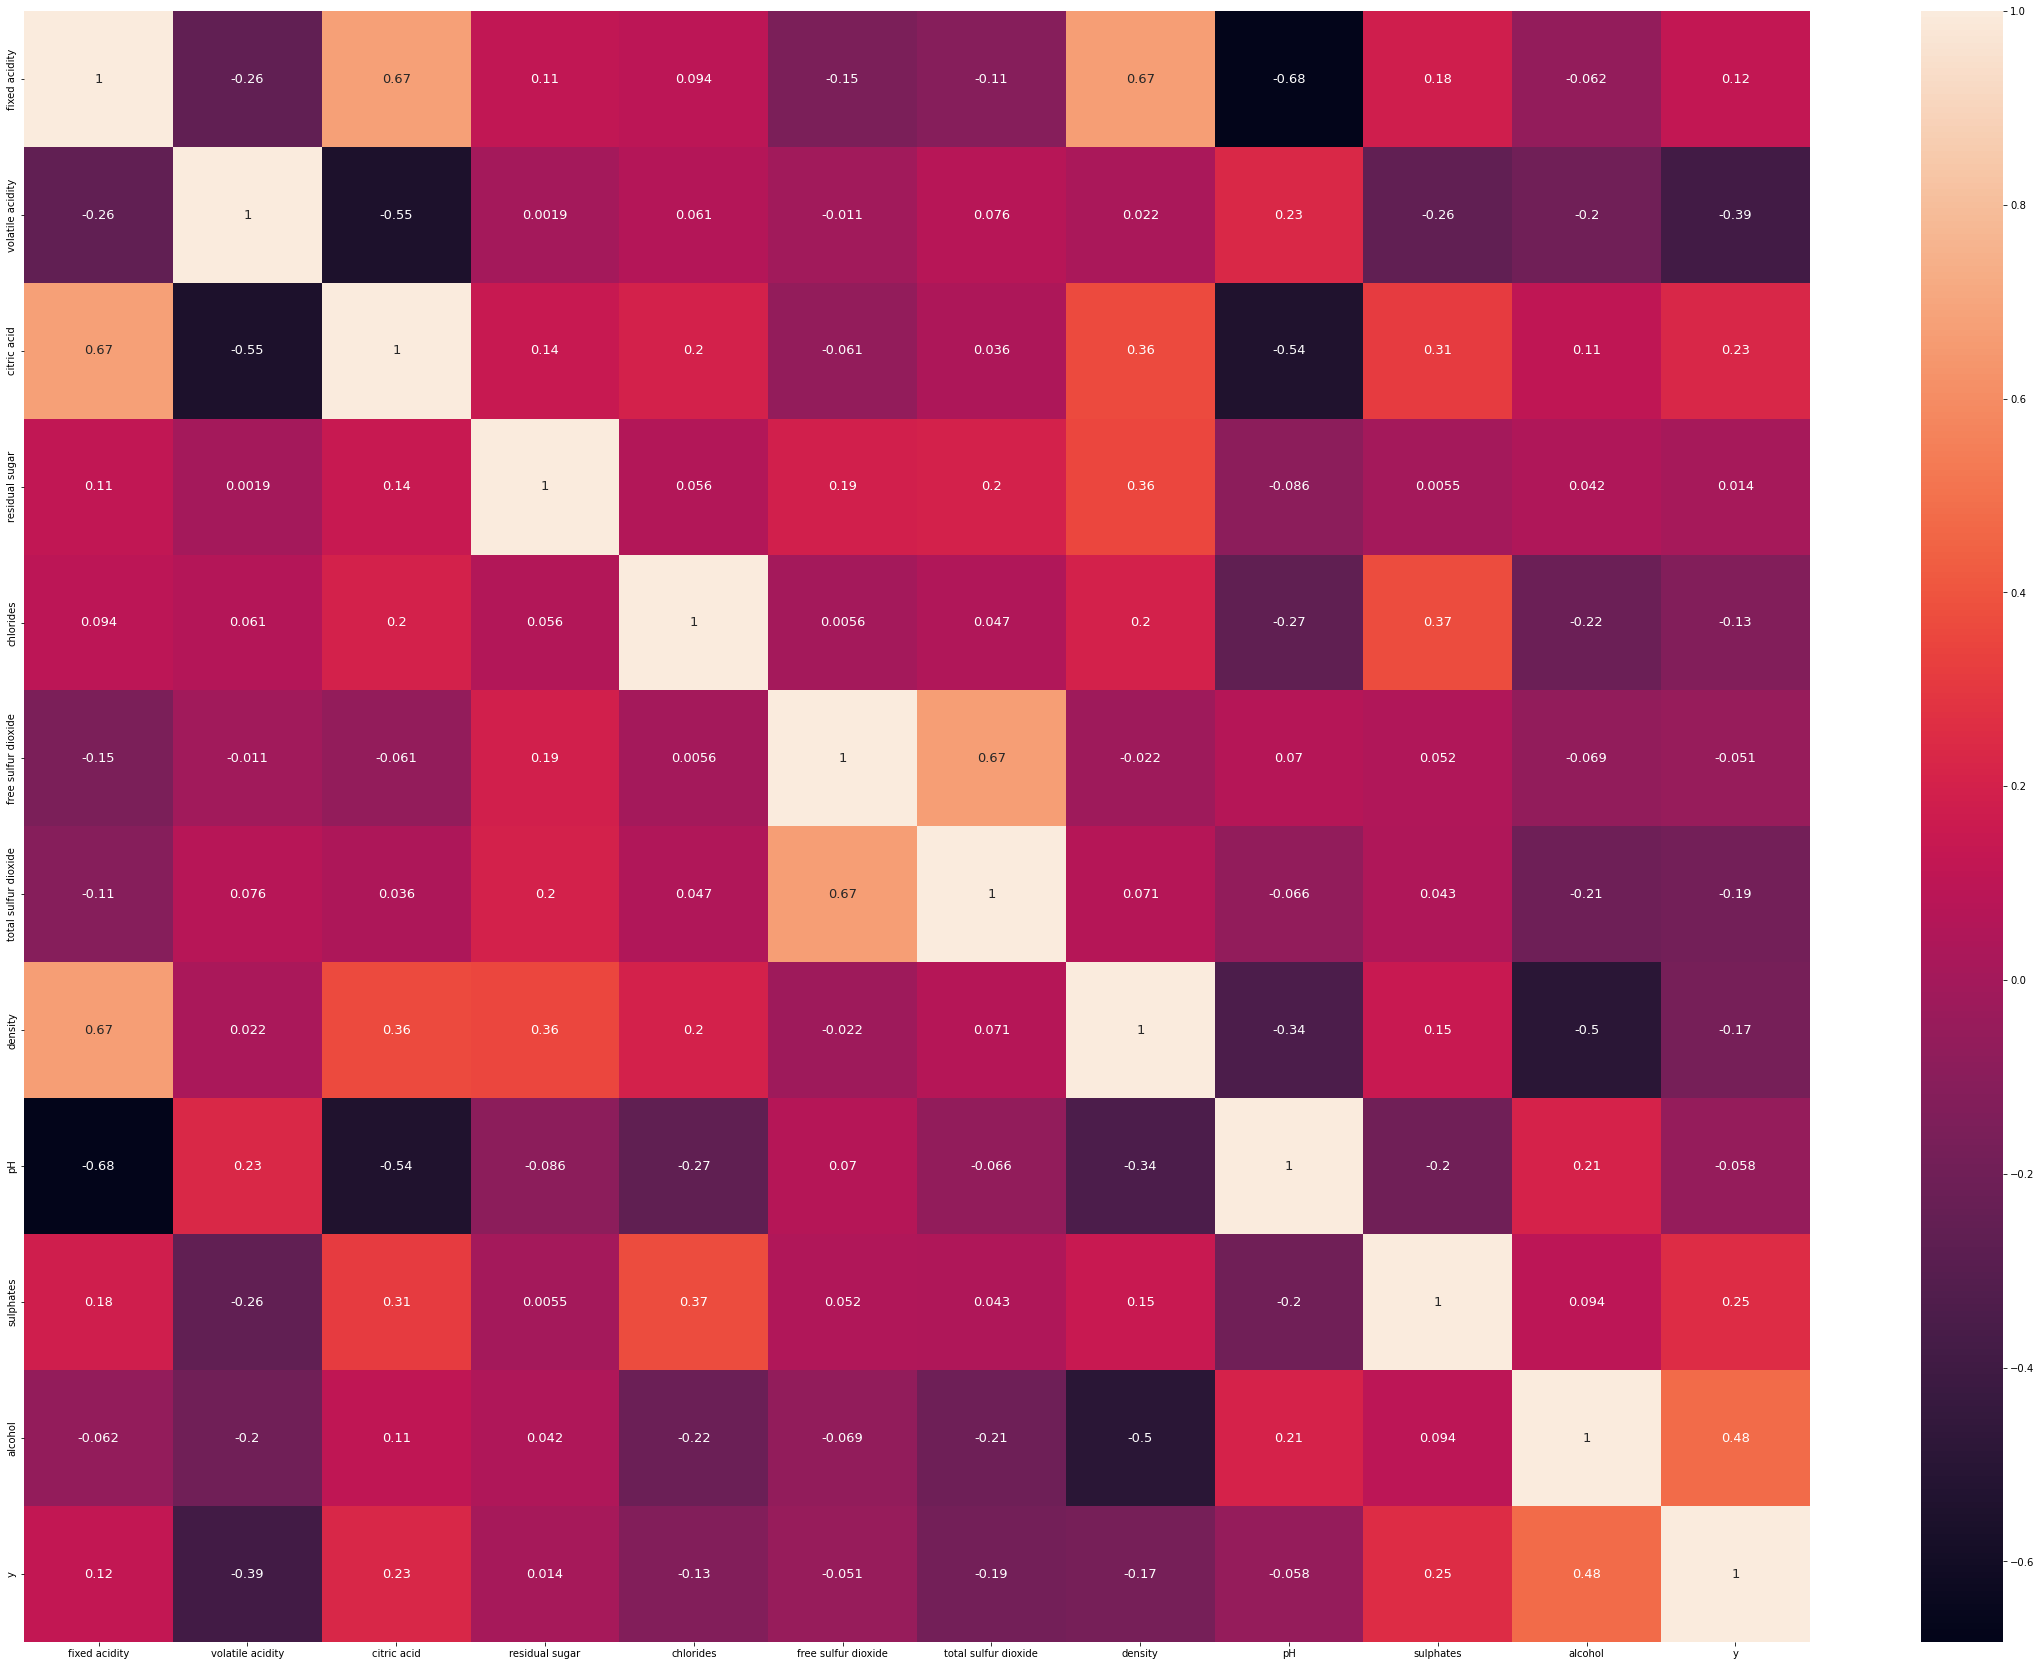

In [39]:
data = X
data['y'] = y
corrmat = data.corr()

fig, ax = plt.subplots(figsize=(40, 30))
sns.heatmap(corrmat, annot=True, annot_kws={'size': 13})

In [40]:
clustering_steps = [
                    ("standard_scaler", StandardScaler()),
                    ("kmeans", KMeans(n_clusters=10))
                   ]

clustering_pipeline = Pipeline(clustering_steps, verbose=True)
clustering_pipeline


Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=10))],
         verbose=True)

In [41]:
def bench_k_means(estimator, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator.fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]




    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (name + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=name, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    # print("For n_clusters =", name,
    #       "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(name):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / name)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # # 2nd Plot showing the actual clusters formed
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #             c=colors, edgecolor='k')

    # # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # # Draw white circles at cluster centers
    # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #             c="white", alpha=1, s=200, edgecolor='k')

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                 s=50, edgecolor='k')

    # ax2.set_title("The visualization of the clustered data.")
    # ax2.set_xlabel("Feature space for the 1st feature")
    # ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % name),
                 fontsize=14, fontweight='bold')





    
    # Show the results
    formatter_result = (
        "{:}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

    return estimator, results

In [42]:
silhouette_avg_n_clusters = []

__________________________________________________________________________________
k	time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
2	0.034s	15779	0.059	0.107	0.076	0.081	0.075	0.009
4	0.057s	12670	0.087	0.090	0.088	0.054	0.084	0.013
6	0.073s	10605	0.189	0.138	0.159	0.108	0.154	-0.066
8	0.103s	9449	0.215	0.134	0.165	0.089	0.159	-0.123
10	0.115s	8781	0.237	0.135	0.172	0.090	0.165	-0.128
15	0.143s	7743	0.280	0.133	0.180	0.065	0.170	-0.278
20	0.131s	7038	0.287	0.121	0.170	0.054	0.158	-0.283
30	0.171s	6096	0.392	0.147	0.214	0.054	0.198	-0.349
50	0.225s	4995	0.460	0.148	0.223	0.041	0.200	-0.373
__________________________________________________________________________________


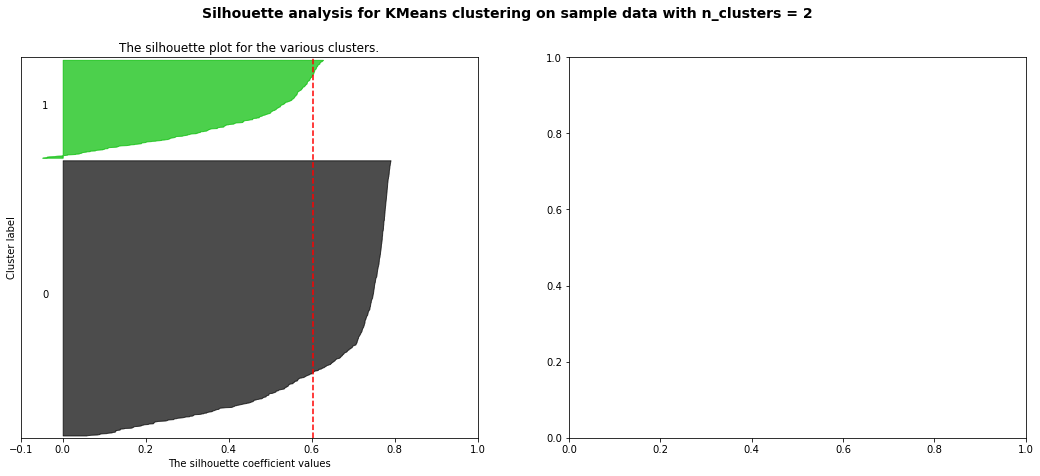

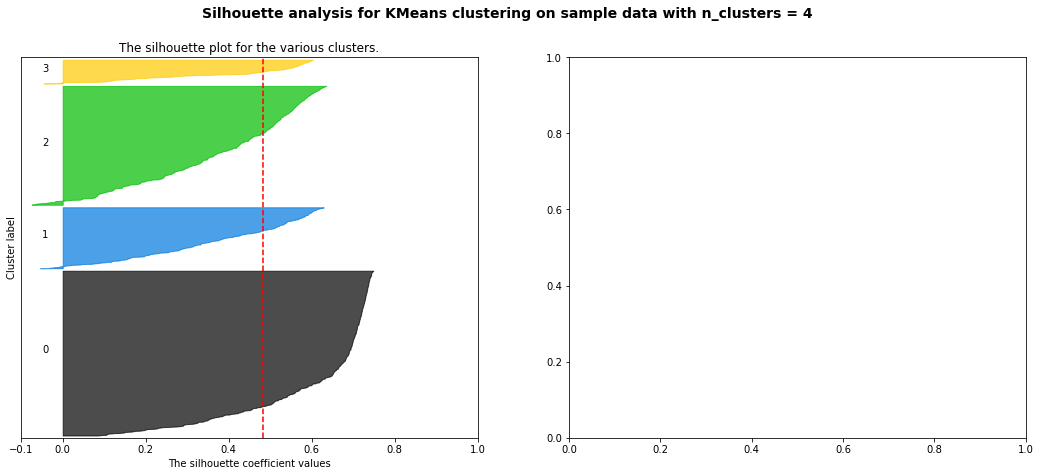

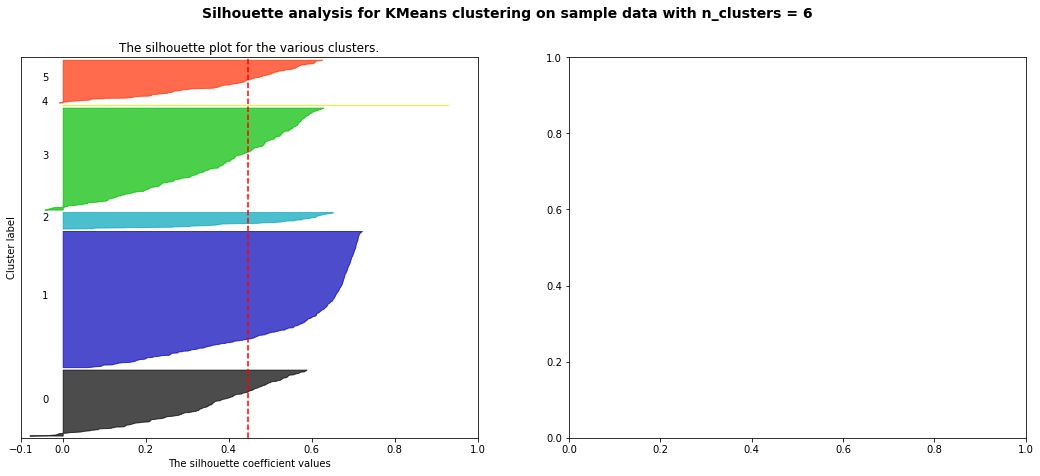

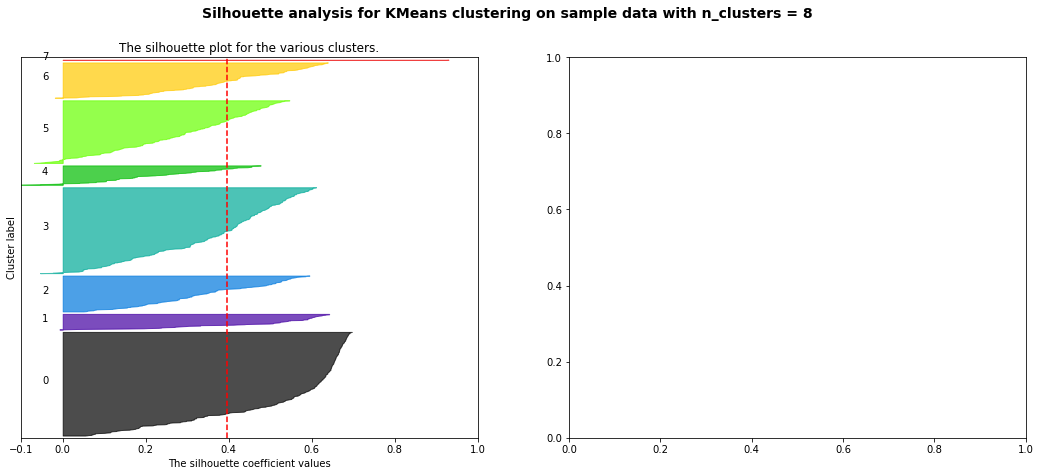

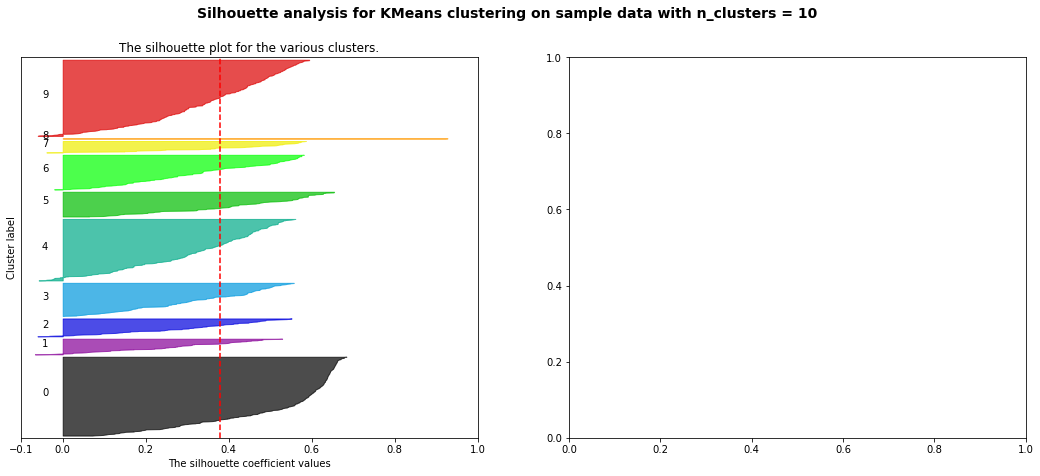

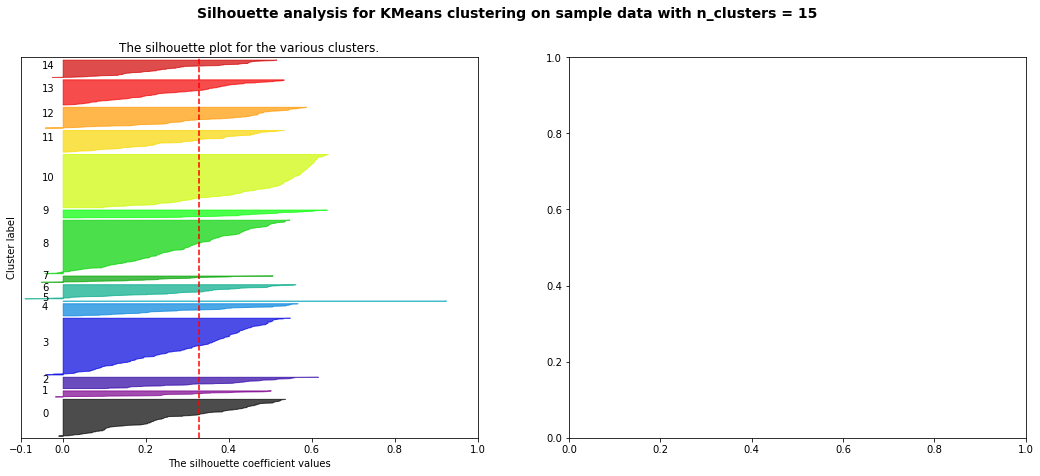

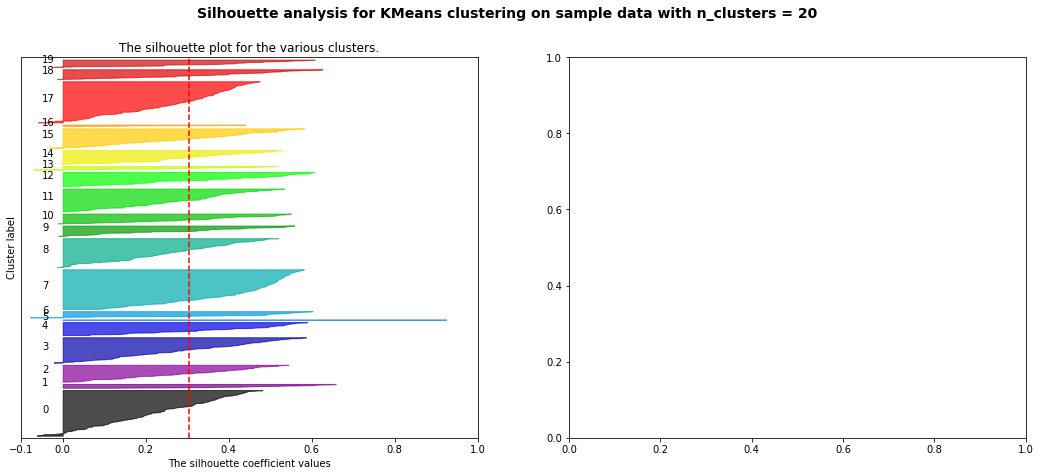

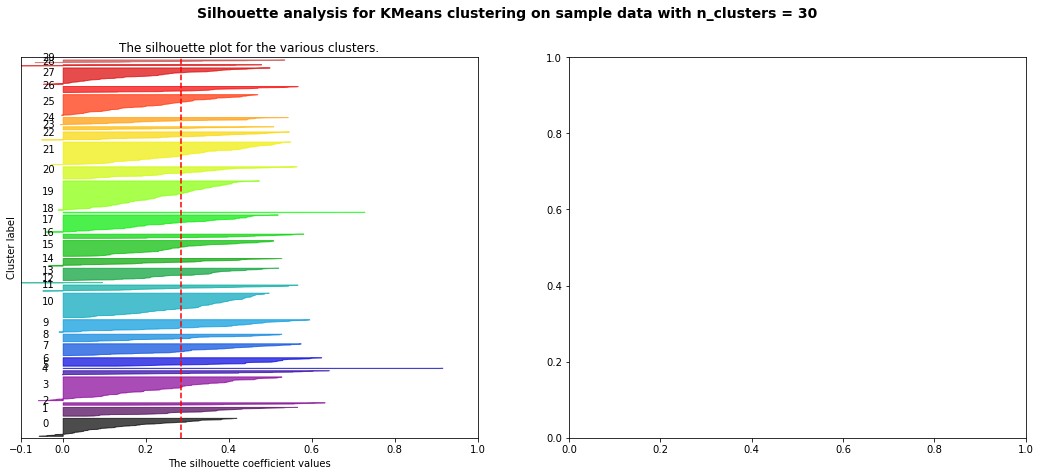

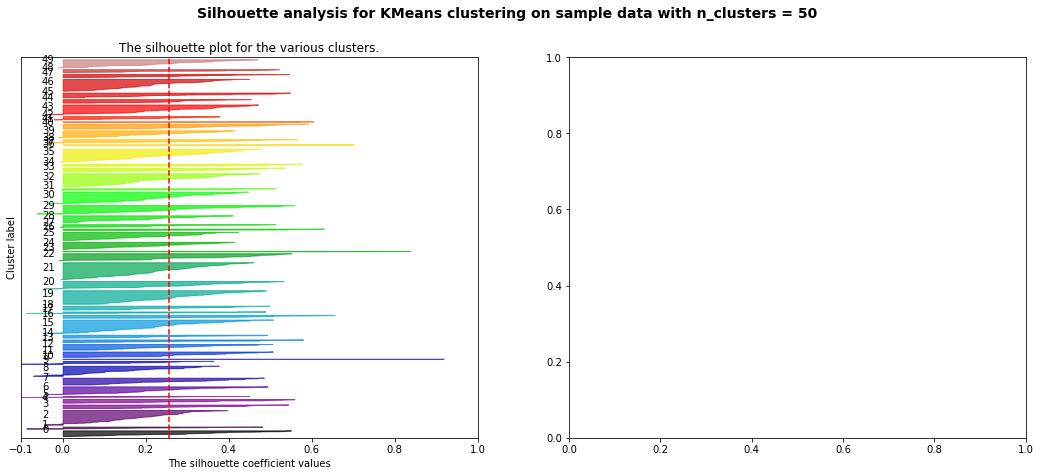

In [43]:
ks = [2, 4, 6, 8, 10, 15, 20, 30, 50]
estimators = []
res = []
labels = ["k", "time", "inertia", "homo", "compl", "v-meas", "ARI", "AMI", "silhouette"]

print(82 * "_")
print("k\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
for k in ks:
    clustering_steps = [
        ("standard_scaler", StandardScaler()),
        ("kmeans", KMeans(n_clusters=k))
    ]
    estimator, result = bench_k_means(Pipeline(clustering_steps, verbose=False), k, X, y)
    estimators.append(estimator)
    res.append(result)
    # print(result)

print(82 * "_")

In [44]:
res = np.array(res).T
print(res.shape)
res[0]

(9, 9)


array([ 2.,  4.,  6.,  8., 10., 15., 20., 30., 50.])

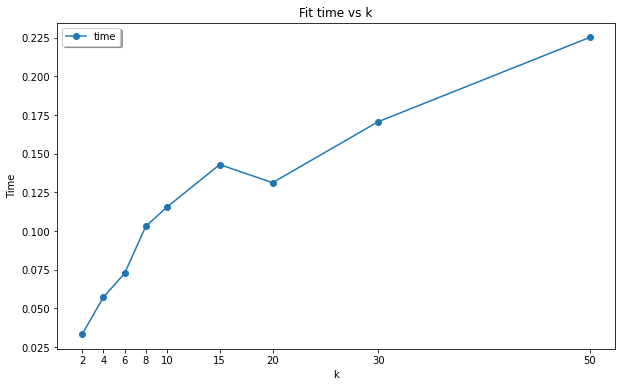

In [45]:
# fit time
fig, g = plt.subplots(1, 1, figsize=size)
plt.xticks(ks, ks)
g.set_title("Fit time vs k")
g.set_ylabel('Time')
g.set_xlabel('k')
g.plot(ks, res[1], marker='o', label=labels[1])
g.legend(shadow=True, fancybox=True)

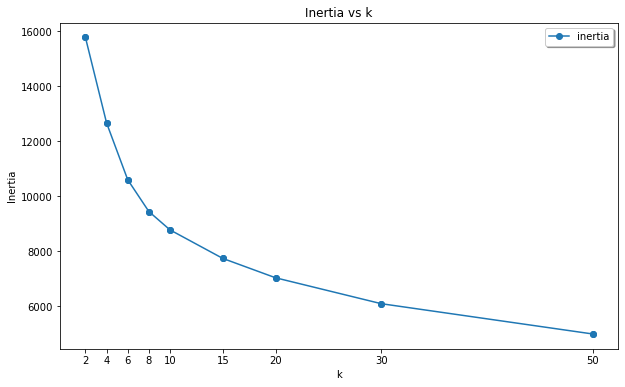

In [46]:
# inertia
fig, g = plt.subplots(1, 1, figsize=size)
plt.xticks(ks, ks)
g.set_title("Inertia vs k")
g.set_ylabel('Inertia')
g.set_xlabel('k')
g.scatter(ks, res[2])
g.plot(ks, res[2], marker='o', label=labels[2])
g.legend(shadow=True, fancybox=True)

[ 0.00874918  0.0133534  -0.06562068 -0.12286204 -0.12789202 -0.27809787
 -0.28278529 -0.34941432 -0.37268173]


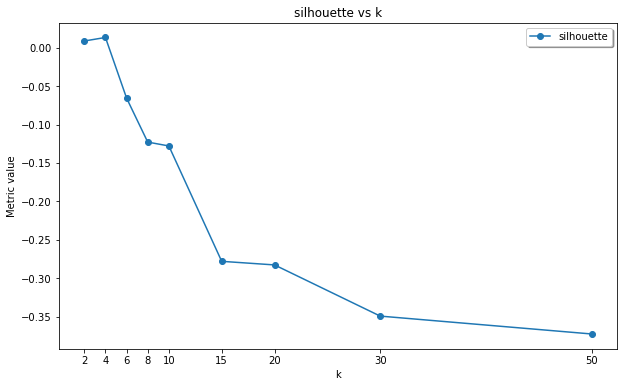

In [47]:
# silhouette
fig, g = plt.subplots(1, 1, figsize=size)
plt.xticks(ks, ks)
# plt.setp(g, xticks=ks, xticklabels=ks)
g.set_title("silhouette vs k")
g.set_ylabel('Metric value')
g.set_xlabel('k')
print(res[-1])
g.plot(ks, res[-1], label=labels[-1], marker='o')
g.legend(shadow=True, fancybox=True)

[0.07465274 0.08447444 0.15446185 0.15860752 0.16460084 0.16987437
 0.15752735 0.19795007 0.20006622]


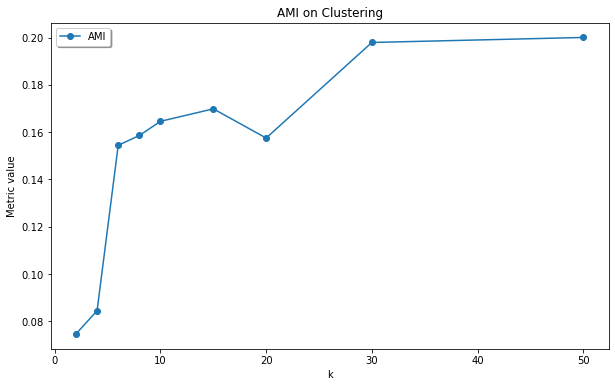

In [48]:
# AMI
fig, g = plt.subplots(1, 1, figsize=size)
g.set_title("AMI on Clustering")
g.set_ylabel('Metric value')
g.set_xlabel('k')
idx = -2
print(res[idx])
g.plot(ks, res[idx], label=labels[idx], marker='o')
g.legend(shadow=True, fancybox=True)


[0.05923734 0.08655031 0.1889472  0.21520354 0.2365004  0.28033522
 0.28654373 0.39211742 0.45950905]
[0.10702661 0.08995929 0.13778875 0.13356389 0.13517951 0.13260153
 0.12119575 0.14730941 0.14754696]
[0.07626393 0.08822188 0.15936293 0.16482859 0.17202978 0.18004152
 0.17034349 0.21416283 0.22337037]
[0.08118233 0.0542284  0.10765851 0.08907516 0.08953009 0.06476092
 0.05445471 0.05435254 0.04066538]
[0.07465274 0.08447444 0.15446185 0.15860752 0.16460084 0.16987437
 0.15752735 0.19795007 0.20006622]


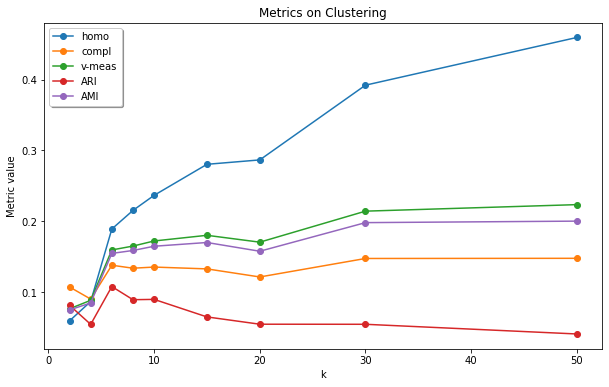

In [49]:
fig, g = plt.subplots(1, 1, figsize=size)
# plt.setp(g, xticks=ks, xticklabels=ks)
g.set_title("Metrics on Clustering")
g.set_ylabel('Metric value')
g.set_xlabel('k')
for idx in range(3, len(res)-1):
    print(res[idx])
    g.plot(ks, res[idx], label=labels[idx], marker='o')
    g.legend(shadow=True, fancybox=True)

# Analysis on the best k using Silhouette Method

In [50]:
clustering_steps = [
    ("standard_scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=10))
]

clustering_pipeline = Pipeline(clustering_steps, verbose=True)
clustering_pipeline

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=10))],
         verbose=True)

In [51]:
estimated = clustering_pipeline.fit_predict(X)

[Pipeline] ... (step 1 of 2) Processing standard_scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.1s


In [52]:
estimated.shape

(1599,)

In [53]:
X.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'y'],
      dtype='object')

In [54]:
trues = np.sum(estimated == y)
print(trues)
print(trues/X.shape[0])

73
0.045653533458411506


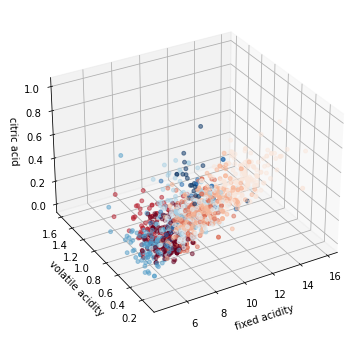

In [55]:
ticks = ['fixed acidity', 'volatile acidity', 'citric acid']
# ticks = ['mean radius', 'mean concavity', 'mean fractal dimension']

fig = plt.figure()
fig.set_size_inches(size)
ax = plt.axes(projection='3d')
ax.scatter3D(X[ticks[0]], X[ticks[1]], X[ticks[2]],
             s=15, c=estimated, cmap='RdBu', alpha=0.5)
plt.xlabel(ticks[0])
plt.ylabel(ticks[1])
ax.set_zlabel(ticks[2])
ax.view_init(30, -120)

KeyError: 'mean radius'

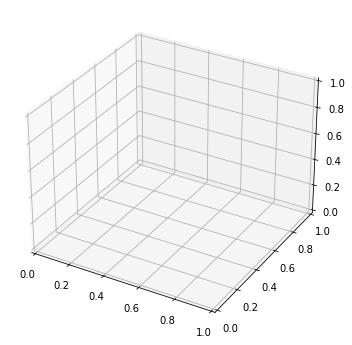

In [56]:
ticks = ['mean radius', 'radius error', 'worst radius']

fig = plt.figure()
fig.set_size_inches(size)
ax = plt.axes(projection='3d')
ax.scatter3D(X[ticks[0]], X[ticks[1]], X[ticks[2]],
             s=15, c=estimated, cmap='RdBu', alpha=0.5)
plt.xlabel(ticks[0])
plt.ylabel(ticks[1])
ax.set_zlabel(ticks[2])
ax.view_init(30, -120)




# Supervised

In [68]:
num_classes = 10

In [69]:
clustering_steps = [
    ("standard_scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=num_classes))
]

clustering_pipeline = Pipeline(clustering_steps, verbose=True)
clustering_pipeline


Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=10))],
         verbose=True)

In [70]:
clustering_pipeline.fit(X)
estimated = clustering_pipeline.predict(X)
print("AMI:")
metrics.adjusted_mutual_info_score(y, clustering_pipeline[-1].labels_)

[Pipeline] ... (step 1 of 2) Processing standard_scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.1s
AMI:


0.17808645708502727

In [71]:
X.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'y'],
      dtype='object')